# This notebook containts analysis for ASO 50m snow depths

In [1]:
import pandas as pd
import numpy as np

from skimage import io
from datetime import timedelta
from datetime import datetime
from scipy.stats import pearsonr
from subprocess import run
import imageio # for gifs
import glob
import os

# Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter 
from matplotlib.ticker import MultipleLocator, FormatStrFormatter 
from matplotlib.dates import MonthLocator
import matplotlib.patheffects as PathEffects
import matplotlib.dates as mdates


from mpl_toolkits.axes_grid1 import make_axes_locatable

### set up paths

In [2]:
# # #ARS
# # mask and DEM
mask_50m_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/tuolx_hetchy_mask_50m.asc'
dem_50m_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/tuolx_dem_50m.asc'

# ASO snow depth surfaces
depth_50m_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/ASO_50m_depth_surfaces/asc/*.asc'
depth_50m_years = list(range(2013,2018))

In [3]:
# # #BSU
# base_path = '/Users/meganmason491/Documents/research/sierra/data/50m_analysis/'

# # mask and DEM
# mask_50m_path = base_path + 'tuolx_hetchy_mask_50m.asc'
# dem_50m_path = base_path + 'tuolx_dem_50m.asc'

# # ASO snow depth surfaces
# depth_50m_path = base_path + 'asc/*.asc'
# depth_50m_years = list(range(2013,2018))

### extract flight dates from filenames

In [4]:
flist = glob.glob(depth_50m_path)
flist = sorted(flist)
print('Number of files as input:', len(flist))

flight_dates = []

for f in sorted(flist):
    dt_str = f.split("/")[-1] #splits on '/' and saves the last one
    dt_str = "".join([c for c in dt_str if c.isnumeric()]) #grabs numeric values for date info
    flight_dates.append(dt_str) #append to flight_date list

# flight_dates # flight dates as strings

flight_dates_dt = [datetime.strptime(flight_date, '%Y%m%d') for flight_date in flight_dates]
# print(flight_dates_dt[1] - flight_dates_dt[0])
# print(type(flight_dates_dt))    

Number of files as input: 47


### show mask, dem, and example lidar

mask shape: (1339, 1374) 
dem shape: (1339, 1374) 
example lidar shape: (1339, 1374)

mask type: <class 'numpy.ndarray'> 
dem type: <class 'numpy.ndarray'> 
example lidar type: <class 'numpy.ndarray'>


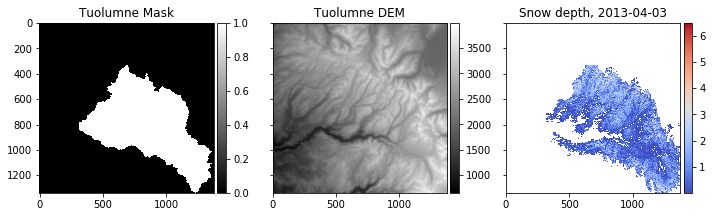

In [5]:
mask_50m = np.loadtxt(mask_50m_path, skiprows=6)
dem_50m = np.loadtxt(dem_50m_path, skiprows=6)
ex_depth = np.loadtxt(flist[0], skiprows=6)

print('mask shape:', mask_50m.shape, 
      '\ndem shape:', dem_50m.shape, 
      '\nexample lidar shape:', ex_depth.shape)

print('\nmask type:', type(mask_50m), 
      '\ndem type:', type(dem_50m), 
      '\nexample lidar type:', type(ex_depth))


f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10,6))
#mask
im1 = ax1.imshow(mask_50m, cmap='gray')
ax1.set_title('Tuolumne Mask')
divider = make_axes_locatable(ax1)
plt.colorbar(im1, cax=divider.append_axes("right", size="5%", pad=0.05))
#dem
im2 = ax2.imshow(dem_50m, cmap='gray')
ax2.set_title('Tuolumne DEM')
divider = make_axes_locatable(ax2)
plt.colorbar(im2, cax=divider.append_axes("right", size="5%", pad=0.05))
#snow depth, 1 of 48
ex_depth[ex_depth<=0]=np.nan
im3 = ax3.imshow(ex_depth, cmap='coolwarm') 
ax3.set_title('Snow depth, {}'.format(flight_dates_dt[0].date())) 
divider = make_axes_locatable(ax3) 
plt.colorbar(im3, cax=divider.append_axes("right", size="5%", pad=0.05))

plt.tight_layout()

In [6]:
flight_period = {}
for year in range(2013,2018):

    flight_period[year] = [flight_dates_dt[i_date+1] - flight_dates_dt[i_date] 
                           for i_date in range(len(flight_dates_dt)-1) 
                           if (year == flight_dates_dt[i_date+1].year) & (year == flight_dates_dt[i_date].year)]
    
    print('frequencies for {}: {} - {} days'.format(year, min(flight_period[year]).days, max(flight_period[year]).days))

frequencies for 2013: 4 - 26 days
frequencies for 2014: 4 - 15 days
frequencies for 2015: 4 - 27 days
frequencies for 2016: 5 - 18 days
frequencies for 2017: 8 - 35 days


### Tuolumne Basin Mean Snow Depth 

In [7]:
# ~~ Function 1, mean snow depth
def mean_snow_depth(depth_array, convert_factor = 1e-3, mask_array = None, mask_value = None):
    '''
    Gets mean snow depth for ASO snow depth surfaces
        args:
            depth_array: numpy array from asc files
            dx: cellsize [m] in x direction
            dy: cellsize [m] in y direction
            convert_factor: (optional, default is 0.001 from mm to m)
            mask_array: (Optional) mask of the area for depth calculation
                       If no mask is provided will calculate for entire array
            mask_value: (Optional) value of the mask to calculate over
                       Default value will be any positive integer
           Note: depth_array and mask_array should cover the same extent 
                 and have the same dx,dy
       return:
           mean_depth: mean depth [m] over the area in mask
                       or the full area in the array if no mask is provided
    '''
    
    if mask_array is None:
        mean_depth = np.nanmean(depth_array[(depth_array > 0)])
        sca = depth_array[(depth_array > 0)].size / mask_array[mask_array == mask_value].size
        
    else:
        mean_depth = np.nanmean(depth_array[[(mask_array == mask_value) & (depth_array > 0)]])
        sca = (depth_array[[(mask_array == mask_value) & (depth_array > 0)]].size / mask_array[mask_array == mask_value].size) * 100
        
    return mean_depth, sca

In [8]:
# call Function 1
mean_depth = []
sca = []

for f in sorted(flist):
    depth_array = np.loadtxt(f, skiprows=6) #load asc files
    mean_d, sca_ = mean_snow_depth(depth_array, mask_array=mask_50m, mask_value=np.max(mask_50m)) #call mean_snow_depth function
    mean_depth.append(mean_d)
    sca.append(sca_)

# mean_depth_df = pd.DataFrame(data = mean_depths, index = flight_dates_dt, columns = ['mean_snow_depth'])
# sca_df = pd.DataFrame(data = sca, index = flight_dates_dt, columns = ['sca'])

df = pd.DataFrame(zip(mean_depth, sca), columns = ['meanSD (m)','SCA (%)'], index = flight_dates_dt)
# df

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [9]:
# ~~ Function 2, peak mean snow depth per year
def get_peak(datetime_list, series_list, years):
    '''
    Calculates yearly peak mean depth
    input:
        datetime_list: list containing the datetime stamps for the time series
        series_list: list with the time series of mean depth values
        years: list with years to analyze
    return:
        peak_df: yearly peak value dataframe with datetime_peak as index and peak value in column
    '''
    
    
    df_series = pd.DataFrame(data = series_list, index = datetime_list, columns = ['series'])
    
    for year in years:
        df_year = df_series.truncate(before = str(year) + '-01', after = str(year) + '-12')
        if year == years[0]:
            peak_df = pd.DataFrame(data = [df_year.max(axis = 0).values[0]], index = [df_year.idxmax(axis = 0).values[0]], columns = ['peak mean depth'])
        else:
            peak_df.loc[df_year.idxmax(axis = 0).values[0]] = df_year.max(axis = 0).values[0]
    
    return peak_df

In [10]:
# call Function 2

# peak mean depths
peak_mean_depth_df = get_peak(flight_dates_dt, mean_depth, depth_50m_years)
# peak_mean_depth_df 

#peak sca
peak_sca_df = get_peak(flight_dates_dt, sca, depth_50m_years)
# peak_sca_df

## PLOT: mean snow & snow covered area

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes in

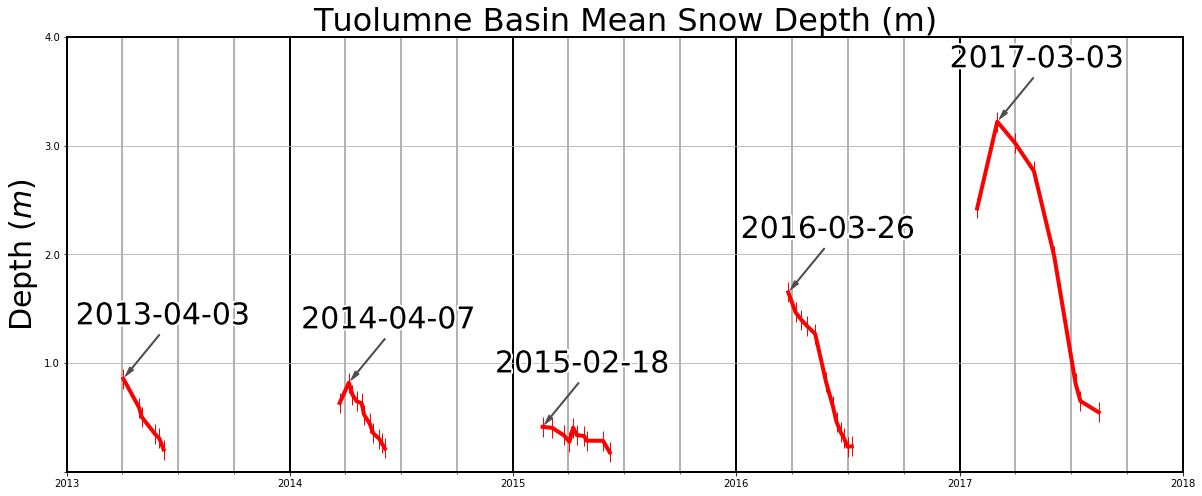

In [11]:
#~~~~use:
# df['meanSD (m)'] (func 1)
# peak_mean_depth_df (func 2)

minorLocator = MultipleLocator(365/2)
fs_titles = 32
fs_labels = 26
fs_axes = 26
fs_text = 26
fs_legend = 26

plt.figure(figsize=(20,8))
ax = plt.subplot(1, 1, 1)

i_plot = 0
for year in depth_50m_years: #(list(range(2013,2018)))
    depth_year = df['meanSD (m)'].truncate(before = str(year) + '-01', after = str(year) + '-12')
    h_plot = plt.plot_date(depth_year.index, depth_year.values, fmt='x', tz=None, xdate=True, ydate=False)
    
    plt.setp(h_plot, marker='|', markersize=20, color='r', linestyle = '-', linewidth = '4')
    
    h_text_date = plt.annotate(str(peak_mean_depth_df.index[i_plot])[:10], xy=(peak_mean_depth_df.index[i_plot], peak_mean_depth_df.iloc[i_plot]), 
                               xytext=(peak_mean_depth_df.index[i_plot]+pd.Timedelta('65 days'), peak_mean_depth_df.iloc[i_plot] + 0.5),
                arrowprops=dict(shrink=0.05, width=1, headlength = 10, headwidth = 5, edgecolor= (0.3, 0.3, 0.3), facecolor= (0.3, 0.3, 0.3)),
                fontsize = fs_text+4, horizontalalignment='center')
    
    h_text_date.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])

    i_plot += 1

plt.title('Tuolumne Basin Mean Snow Depth (m)', fontsize = fs_titles)
plt.ylabel('Depth $(m)$',fontsize = fs_labels + 4)
plt.axes().xaxis.set_minor_locator(MonthLocator(bymonth = [4, 7, 10]))
plt.rc('xtick', labelsize = fs_axes+10)    # fontsize of the tick labels
plt.rc('ytick', labelsize = fs_axes+4)    # fontsize of the tick labels
plt.ylim([0, 4])
plt.grid(True)
plt.grid(axis='both', color=(0.7, 0.7, 0.7), which='minor', linestyle='-', linewidth=2)
plt.grid(axis='x', color='k', which='major', linestyle='-', linewidth=2)
plt.xlim([pd.to_datetime('2013-01-01'), pd.to_datetime('2018-01-01')])

y_ticks = np.array(list(range(0, 45, 10)))/10
y_ticklabels = [str(y_tick) for y_tick in y_ticks]
y_ticklabels[0] = ''
plt.yticks(y_ticks, y_ticklabels)

ax.spines['top'].set_linewidth(2.0)
ax.spines['bottom'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)

# plt.savefig('/home/meganmason/Documents/projects/thesis/figures/working/50m_depth/mean_snow_depth.png', dpi=300)

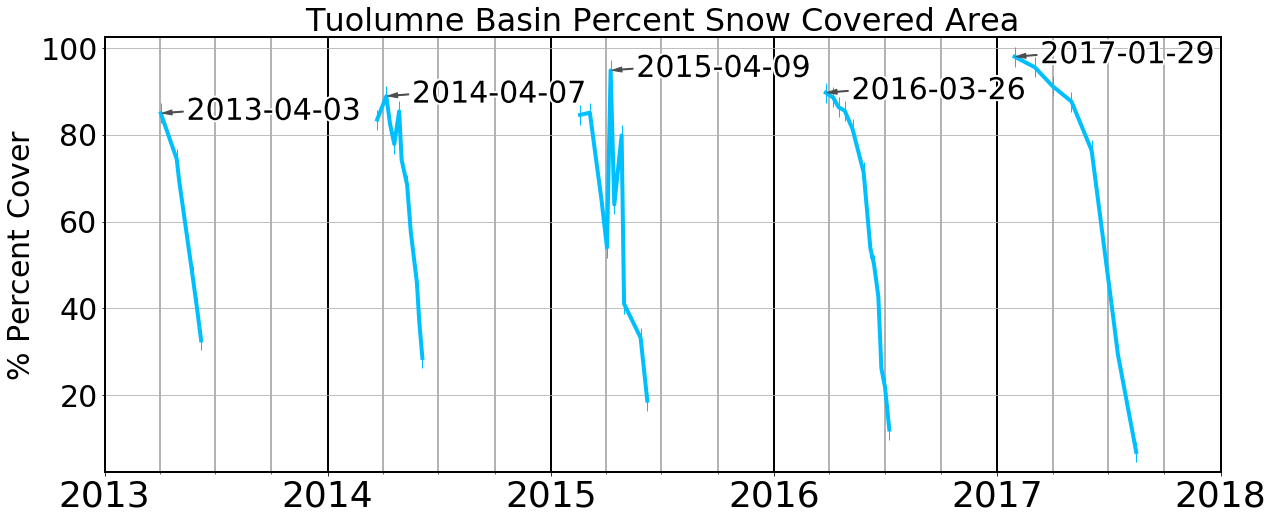

In [12]:
#use:
# df['SCA (%)'] (func 1)
# peak_sca_df (func 2)

minorLocator = MultipleLocator(365/2)
fs_titles = 32
fs_labels = 26
fs_axes = 26
fs_text = 26
fs_legend = 26

plt.figure(figsize=(20,8))
ax = plt.subplot(1, 1, 1)

i_plot = 0
for year in depth_50m_years: #(list(range(2013,2018)))
    depth_year = df['SCA (%)'].truncate(before = str(year) + '-01', after = str(year) + '-12')
    h_plot = plt.plot_date(depth_year.index, depth_year.values, fmt='x', tz=None, xdate=True, ydate=False)
    
    plt.setp(h_plot, marker='|', markersize=20, color='deepskyblue', linestyle = '-', linewidth = '4')
    
    h_text_date = plt.annotate(str(peak_sca_df.index[i_plot])[:10], xy=(peak_sca_df.index[i_plot], peak_sca_df.iloc[i_plot]), 
                               xytext=(peak_sca_df.index[i_plot]+pd.Timedelta('185 days'), peak_sca_df.iloc[i_plot] - 1.5),
                arrowprops=dict(shrink=0.05, width=1, headlength = 10, headwidth = 5, edgecolor= (0.3, 0.3, 0.3), facecolor= (0.3, 0.3, 0.3)),
                fontsize = fs_text+4, horizontalalignment='center')
    
    h_text_date.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])

    i_plot += 1

plt.title('Tuolumne Basin Percent Snow Covered Area', fontsize = fs_titles)
plt.ylabel('$\%$ Percent Cover', fontsize = fs_labels + 4)
plt.axes().xaxis.set_minor_locator(MonthLocator(bymonth = [4, 7, 10]))
plt.rc('xtick', labelsize = fs_axes+10)    # fontsize of the tick labels
plt.rc('ytick', labelsize = fs_axes+4)    # fontsize of the tick labels
# plt.ylim([0, 4])
plt.grid(True)
plt.grid(axis='both', color=(0.7, 0.7, 0.7), which='minor', linestyle='-', linewidth=2)
plt.grid(axis='x', color='k', which='major', linestyle='-', linewidth=2)
plt.xlim([pd.to_datetime('2013-01-01'), pd.to_datetime('2018-01-01')])

ax.spines['top'].set_linewidth(2.0)
ax.spines['bottom'].set_linewidth(2.0)
ax.spines['left'].set_linewidth(2.0)
ax.spines['right'].set_linewidth(2.0)

# plt.savefig('/home/meganmason/Documents/projects/thesis/figures/working/50m_depth/sca_depth.png', dpi=300)

In [13]:
# What are the maximums for each year??
depth_max = []
for f in sorted(flist):
    depth_array = np.loadtxt(f, skiprows=6) #load lidar asciis
    d_max = depth_array[mask_50m == 1].max()
    depth_max.append(d_max)
depth_max
max_depth_df = pd.DataFrame(data = depth_max, index = flight_dates_dt, columns = ['max_snow_depth'])
# max_depth_df

## Histograms :)

In [14]:
def hist2series(bin_edges, hist_series):
    '''
    Generates x-y series to plot histograms as a line/step plot
    Parameters: bin_edges: (ndarray, list) monotonically increasing array of bin edges,
                            excluding the rightmost edge
                hist_series: (ndarray, list) The values of the histogram
                            (len(bin_edges) -1)
                Note: bin_edges and hist_series should be the same length
    Returns:
            x_series: (list) x values for plotting
            y_series: (list) y values for plotting
    '''
    
    x_series = []
    y_series = []
    
    for i_bin in range(len(bin_edges) - 1):
        
        x_series += [bin_edges[i_bin], bin_edges[i_bin+1]]
        y_series += [hist_series[i_bin], hist_series[i_bin]]
        
    return x_series, y_series

In [15]:
bin_size = 10 #0.10 #m (5cm)
max_depth = 2500
bins_ll = np.arange(0, max_depth, bin_size)

# bin_edges = np.arrange(0, 25, bin_size)

depth_tuolumne_hist = {}

for i, flight_date_dt in enumerate(flight_dates_dt):
    
    hist_aux = pd.DataFrame(data = np.nan, index = bins_ll[:-1], columns = [flight_date_dt])
    
    depth_array = np.loadtxt(flist[i], skiprows=6) * 100 #load lidar asciis
    
#     depth_array=depth_array*100
    
    hist_aux[flight_date_dt] = np.histogram(depth_array[(depth_array > 0) & (mask_50m == 1)], bins = bins_ll)[0] #saves just histogram result
    
    depth_tuolumne_hist[flight_date_dt] = hist_aux
# depth_tuolumne_hist

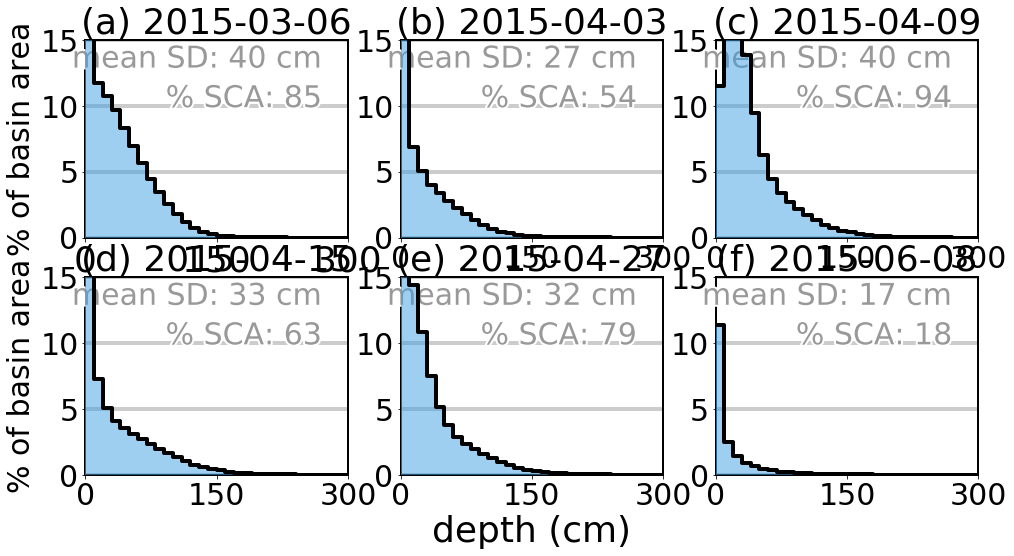

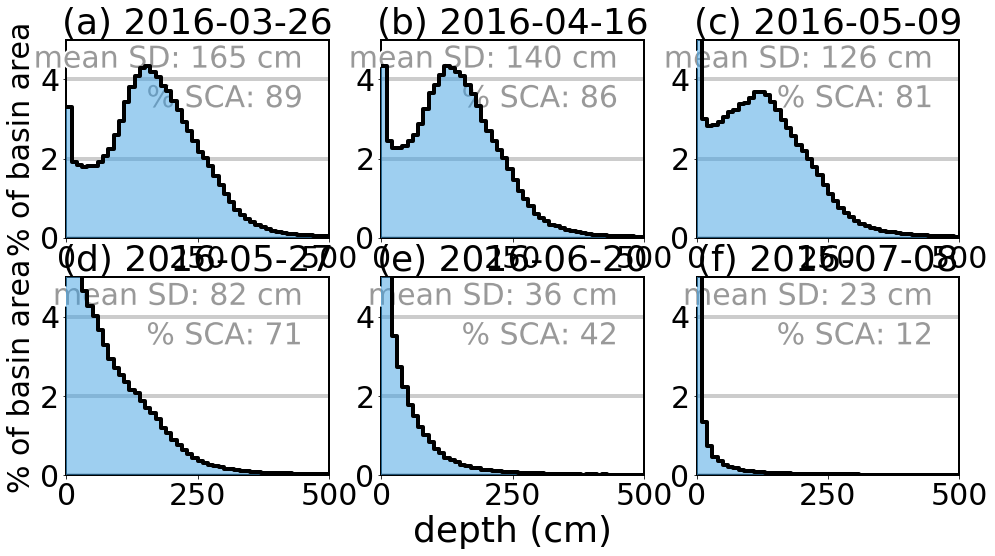

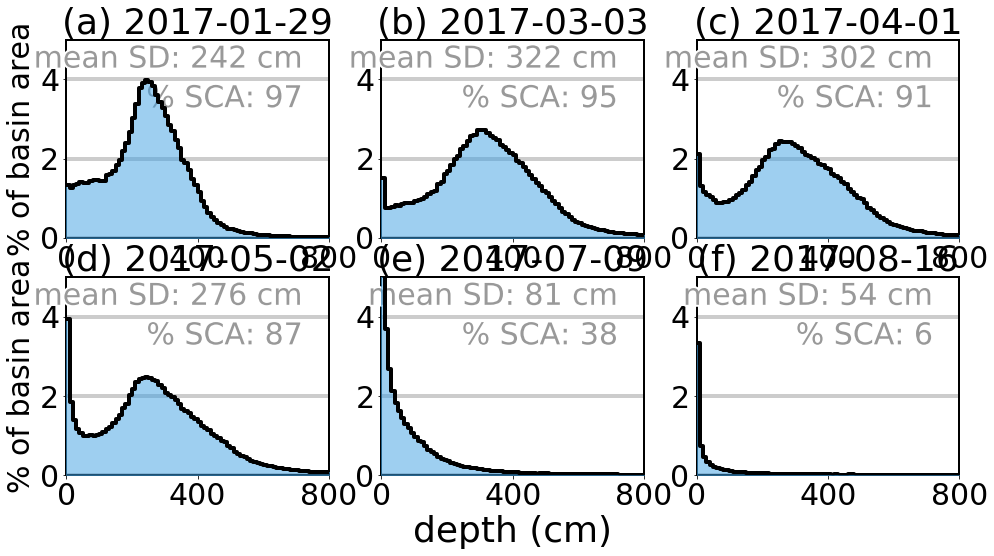

In [16]:
# plots with optimal bins

# low: 2015
# middle: 2016
# high: 2017

dates_to_plot_dict = {2015:['20150306', '20150403', '20150409', '20150415', '20150427', '20150608'],
                      2016:['20160326', '20160416', '20160509', '20160527', '20160620', '20160708'],
                      2017:['20170129', '20170303', '20170401', '20170502', '20170709', '20170816']}

color_plots = [(62/255, 160/255, 227/255), 'k']
max_depth = {2015:300, 2016:500, 2017:800}
max_y = {2015:15, 2016:5, 2017:5}
title_letter = 'abcdef'


for year in dates_to_plot_dict: #('15,'16,'17)
       
#     plt.figure(figsize = (24, 16))
    plt.figure(figsize = (16, 8))
    i_plot = 1
    
    for year_date in dates_to_plot_dict[year]:
        
        #~~~ plot
        ax = plt.subplot(2, 3, i_plot)
        
        #extract data from dataframe
        year_date_dt = datetime.strptime(year_date, '%Y%m%d') #formats the strings in the dates_to_plot_dict
        depth_hist_aux = depth_tuolumne_hist[year_date_dt] #pulls individual histogram for each date
        
        # compute x and y series for step plot from histogram values
            # x'= hist_xy[0] and 'y'= hist_xy[1]
            # y = % of basin, divide by size of pixels in mask and *100 for percent of basin       
        hist_xy = hist2series(depth_hist_aux.index, depth_hist_aux[year_date_dt].values) 
        ax.plot(hist_xy[0], 100 * np.array(hist_xy[1])/mask_50m[mask_50m == 1].size,
                label=year_date_dt, linewidth = 4, color = 'k', zorder = 5)
        plt.fill_between(hist_xy[0], 100 * np.array(hist_xy[1])/mask_50m[mask_50m == 1].size, alpha = 0.5, color = color_plots[0], zorder = 4) #color_plots different than ET
        
        
        
        #~~~ format
        plt.title('(' + title_letter[i_plot-1] + ') ' + str(year_date_dt.strftime('%Y-%m-%d')), fontsize = fs_titles+4)
    
        if i_plot == 5:
            plt.xlabel('depth (cm)',fontsize = fs_labels + 10)
    
        if i_plot in [1, 4]:
            plt.ylabel('% of basin area',fontsize = fs_labels + 4)

        plt.xticks(np.arange(0, 3*max_depth[year]/2, max_depth[year]/2))
        plt.rc('xtick', labelsize = fs_axes+4)    
        plt.rc('ytick', labelsize = fs_axes+4)    

        plt.grid(axis='y', color=(0.8, 0.8, 0.8), which='major', linestyle='-', linewidth=4)

        plt.xlim([0, max_depth[year]])
        plt.ylim([0, max_y[year]])

        ax.spines['top'].set_linewidth(2.0)
        ax.spines['bottom'].set_linewidth(2.0)
        ax.spines['left'].set_linewidth(2.0)
        ax.spines['right'].set_linewidth(2.0)
        
        sca_percent = depth_hist_aux[year_date_dt].values.sum() / mask_50m[mask_50m == 1].size * 100
        sca_text = plt.annotate('% SCA: ' + str(int(sca_percent)), 
                                xy = (0.9*max_depth[year], 0.66*max_y[year]), 
                                fontsize = fs_labels+4, color = (0.6, 0.6, 0.6), alpha = 1, rotation = 0, 
                                horizontalalignment = 'right')
        sca_text.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])

        mean_text = plt.annotate('mean SD: ' + str(int(df['meanSD (m)'].loc[year_date_dt] *100)) + ' cm', 
                                xy = (0.9*max_depth[year], 0.86*max_y[year]), 
                                fontsize = fs_labels+4, color = (0.6, 0.6, 0.6), alpha = 1, rotation = 0, 
                                horizontalalignment = 'right')
        mean_text.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        
        
        i_plot +=1
        
#     plt.savefig('/home/meganmason/Documents/projects/thesis/figures/working/50m_depth/hist_sca_depth_{}.png'.format(year), dpi=150)

## time for elevation bands !

In [17]:
def mean_sd_band(depth_array, elev_array, min_elev, max_elev, mask_array= None, mask_value= None):
   
    '''
    This method computes the mean snow depth for different elevation bands 
    
        args:
            depth_array: np array of snow depths, [cm]
            elev_array: dem of basin, extent matches depth_array, [m]
            min_elev: lower limit of elevation band (inclusive)
            max_elev: upper limit of elevation band (exclusive)
            mask_array: (Optional) mask of the area for SWE calculation
                         If no mask is provided will calculate for entire array
            mask_value: (Optional) value of the mask to calculate over
                        Default value will be any positive integer
        
        returns: mean depth at each elevation band, np float
            
    '''
    
    if mask_array is None:
        mean_depth_band = np.nanmean([depth_array[(elev_array >= min_elev) & (elev_array < max_elev)]])
    
    else:
        depth_array = depth_array[(mask_array == mask_value)]
        elev_array = elev_array[mask_array == mask_value]
        depth_at_bands = depth_array[(elev_array >= min_elev) & (elev_array < max_elev)]
        mean_depth_band = np.nanmean(depth_at_bands[depth_at_bands > 0])
        
    return mean_depth_band

In [22]:
elev_sd_df = pd.DataFrame()

band_width = 250
lower_limits = list(range(1500,4000, band_width))
upper_limits = list(range(1750,4250,band_width))


for i, flight_date_dt in enumerate(flight_dates_dt):
    
    depth_array = np.loadtxt(flist[i], skiprows=6) * 100 #load lidar files, [cm]
    date_key = {'flight_date': flight_date_dt} #dict, key is flight date
    
    for lower_limit in lower_limits:
    
        mean_sd = mean_sd_band(depth_array, dem_50m, lower_limit, lower_limit + band_width, mask_50m, mask_value=np.max(mask_50m)) #get mean for each elevation band
        date_key[lower_limit] = mean_sd #store mean at each band for every flight date
    
    elev_sd_df = elev_sd_df.append(date_key, ignore_index=True)
    
elev_sd_df.set_index('flight_date', inplace=True)

export_csv = elev_sd_df.to_csv('/home/meganmason/Documents/projects/thesis/figures/tables/elev_sd_df.csv', index = True, header=True) #ind=T stores row names
# elev_sd_df

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750
flight_date,,,,,,,,,,
2013-04-03,4.514585,3.850358,14.339708,36.072279,58.112997,87.700199,128.861921,126.605803,104.818234,105.368078
2013-04-29,5.832937,4.436740,3.341896,11.502364,27.717971,54.510437,90.252586,92.942906,84.584142,98.175346
2013-05-03,3.572074,4.403890,3.382218,8.018536,20.562805,44.181469,75.635383,82.016782,79.767173,104.035149
2013-05-25,6.574275,7.942248,4.749715,5.435505,9.375270,22.228715,42.812841,55.286633,66.058175,96.278424
2013-06-01,13.414331,8.137223,6.767855,3.843804,6.206421,18.179772,36.013413,47.450660,61.233021,93.082904
2013-06-08,10.277655,10.471301,6.617821,3.810265,3.395333,8.761268,21.269488,32.905235,50.738618,86.898623
2014-03-23,1.214687,1.885160,10.164750,28.732645,42.596821,61.306597,91.581751,97.224696,87.715796,96.595887
2014-04-07,1.279070,3.877938,13.128254,38.699390,58.784168,84.603141,122.590871,126.762463,115.069203,122.908246
2014-04-13,2.968933,3.848059,5.296462,24.944737,44.341030,69.670649,103.405339,108.060962,102.750521,114.495231


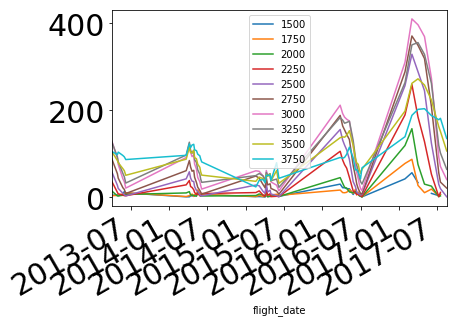

In [25]:
elev_sd_df.plot()
elev_sd_df

Text(2013-03-30 00:00:00, 36.072279268776974, '2250-2500')
Text(2013-03-30 00:00:00, 58.112996730840464, '2500-2750')
Text(2013-03-30 00:00:00, 87.70019864511426, '2750-3000')
Text(2013-03-30 00:00:00, 128.86192116728722, '3000-3250')
Text(2013-03-30 00:00:00, 126.60580268261326, '3250-3500')
Text(2013-03-30 00:00:00, 126.60580268261326, '3250-3500')
Text(2013-03-30 00:00:00, 126.60580268261326, '3250-3500')
Text(2013-03-30 00:00:00, 126.60580268261326, '3250-3500')
Text(2013-03-30 00:00:00, 126.60580268261326, '3250-3500')
Text(2013-03-30 00:00:00, 126.60580268261326, '3250-3500')
Text(2013-03-30 00:00:00, 126.60580268261326, '3250-3500')
Text(2013-03-30 00:00:00, 126.60580268261326, '3250-3500')
Text(2013-03-30 00:00:00, 126.60580268261326, '3250-3500')
Text(2013-03-30 00:00:00, 126.60580268261326, '3250-3500')
Text(2013-03-30 00:00:00, 126.60580268261326, '3250-3500')
Text(2013-03-30 00:00:00, 126.60580268261326, '3250-3500')
Text(2013-03-30 00:00:00, 126.60580268261326, '3250-3500'

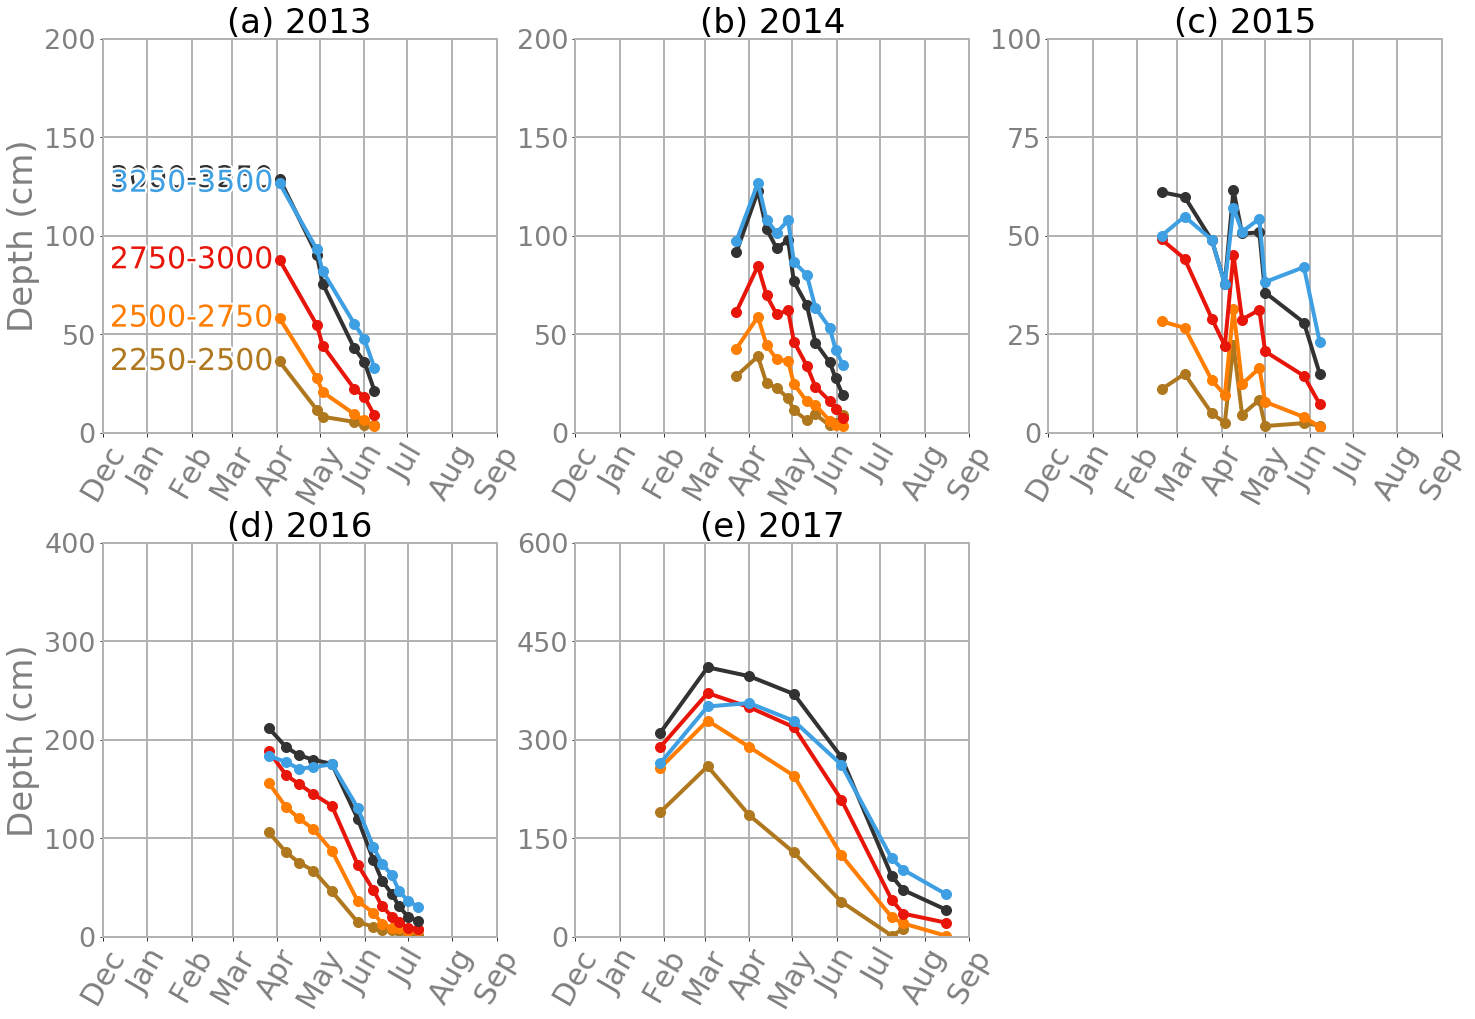

In [100]:
# plot mean snow depth at 250m elevation bands


# area_250m_elev_bands = {lower_limit:0 for lower_limit in lower_limits}

#set up

fs_titles = 34
fs_labels = 30
fs_axes = 30
fs_text = 26
fs_legend = 30

title_letter = ['(a)', '(b)', '(c)', '(d)', '(e)']
marker = ['.', 'o', 'v', 'p', 'P', '*', '1', '+', '^', 'x']

colors = [(175/255, 120/255, 30/255),
          (255/255, 125/255, 1/255), 
          (232/255, 21/255, 10/255),
          (50/255, 50/255, 50/255),
          (62/255, 160/255, 227/255)]

color_grey = 0.8
grey_text_intensity = 0.5
color_grey_grid = 0.7
color_taf = (color_grey, color_grey, color_grey)
color_grid = (color_grey_grid, color_grey_grid, color_grey_grid)
color_month = (color_grey, color_grey, color_grey)
color_grey_text = (grey_text_intensity, grey_text_intensity, grey_text_intensity)
letter_count = 0

plt.figure(figsize = (24, 17))

i_plot = 1


for year in depth_50m_years:
    
    ax = plt.subplot(2,3,i_plot)
    
    depth_plot = elev_sd_df.truncate(before = str(year) + '-01', after = str(year) + '-12')
    
    color_count = 0
    max_plot = 0
    
    for lower_limit in lower_limits[3:-2]:
        
        color_band = colors[color_count]
        maker_band = marker[color_count]
        color_count += 1      
        
    
        plt.plot_date(depth_plot.index, depth_plot[lower_limit],
                      fmt='-', tz=None, xdate=True, ydate=False, label=int(lower_limit+band_width/2),
                      color = color_band, linestyle = '-', linewidth = '4', marker = 'o', 
                      markersize = 10, markerfacecolor = color_band)
        
        max_plot = max(max_plot, depth_plot[lower_limit].max())
        str_legend = str(int(lower_limit)) + '-' + str(int(lower_limit + band_width))
        
#         print('string legend:', str_legend)
        
        if year == 2013:
            
            h_text = plt.text(depth_plot.index[0] - pd.Timedelta('4 days'), depth_plot[lower_limit][0], str_legend,
                              color = color_band, fontsize = fs_legend, 
                              horizontalalignment = 'right', verticalalignment = 'center')
#             ax.annotate(str_legend, (depth_plot.index[0] - pd.Timedelta('4 days'), depth_plot[lower_limit][0]), color=color_band)
#     print('x:', (depth_plot.index[0] - pd.Timedelta('4 days'))
            h_text.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        print(h_text)

        

    plt.title(title_letter[letter_count] + ' ' + str(year), fontsize = fs_titles)
    letter_count += 1
    
    if year in [2013, 2016]:
        plt.ylabel('Depth (cm)',fontsize = fs_labels+4, color = color_grey_text)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.xticks(fontsize = fs_axes, rotation = 60, horizontalalignment = 'center', color = color_grey_text)
    
    
    if year in [2014, 2015]:
        max_y = np.ceil(max_plot / 100) * 100
        
    else:
        max_y = np.ceil(max_plot / 200) * 200
        
    y_step = int(max_y / 4)
    y_ticks_marks = np.array(list(range(5))) * y_step
    y_ticks_labels = y_ticks_marks
    plt.ylim([0, max_y])
    plt.yticks(y_ticks_marks, y_ticks_labels.astype(int), fontsize = fs_axes-3, color = color_grey_text)
    plt.xlim([pd.to_datetime(str(year-1) + '-12-01'), pd.to_datetime(str(year) + '-09-01')])
    plt.grid(True)
    plt.grid(axis='both', color = color_grid, which = 'major', linestyle = '-', linewidth=2)
    
    ax.spines['top'].set_linewidth(2.0)
    ax.spines['top'].set_color(color_grid)
    ax.spines['bottom'].set_linewidth(2.0)
    ax.spines['bottom'].set_color(color_grid)
    ax.spines['left'].set_linewidth(2.0)
    ax.spines['left'].set_color(color_grid)
    ax.spines['right'].set_linewidth(2.0)
    ax.spines['right'].set_color(color_grid)
    
    ratio = 1.0
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)        
        
    
    i_plot += 1
    
        
        

In [ ]:
lower_limits
lower_limits[3:-2]

In [96]:
depth_plot

,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750
flight_date,,,,,,,,,,
2017-01-29,42.463473,77.953369,119.143283,189.443443,256.747449,288.601565,310.345496,263.901948,198.230827,139.366025
2017-03-03,56.633266,87.440184,157.818192,259.409360,329.029690,370.977123,410.192994,350.541724,262.140818,188.566743
2017-04-01,33.717343,27.404743,75.555302,184.854852,288.784252,349.453626,396.688627,355.758941,272.489228,202.286297
2017-05-02,NaN,10.701725,30.368192,128.133677,245.038386,319.048190,369.547292,328.538392,258.231232,203.820193
2017-06-04,9.093103,18.969872,25.744594,53.225090,124.124646,208.837267,273.619172,261.986233,223.668957,187.998872
2017-07-09,3.880952,2.998246,1.567133,1.568299,29.867497,56.361292,92.642266,119.334254,162.523719,178.413533
2017-07-17,7.336585,6.169753,3.314865,11.341857,20.053867,35.076087,71.089623,101.928402,151.424526,181.674684
2017-08-16,NaN,NaN,NaN,NaN,1.200000,21.148447,40.841626,64.412113,106.580728,135.199706


In [ ]:
depth_plot